In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,avg, sum, to_date, month, count
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Create a spark Session
spark = SparkSession.builder \
    .appName("Amazon") \
    .getOrCreate()

csv_file_path = r"Dataset\Amazon.csv"
df = spark.read.csv(csv_file_path, header="true", inferSchema=True)


In [37]:
df_clean = (
    df
    .filter(
        ((col("Status") == "Shipped") | (col("Status") == "Cancelled")) & 
        (col("Fulfilment") == "Amazon") & 
        (col("Sales Channel ") == "Amazon.in")
    )
)

df_clean = df_clean.withColumn("parsed_date", to_date("Date", "MM-dd-yy"))
df_clean = df_clean.withColumn("month", month("parsed_date"))
df_clean=df_clean.drop("fulfilled-by", "Unnamed: 22", " Sales Channel ", "promotion-ids", "Date")
df_clean= df_clean.dropna(subset=["Order ID", "Status", "Fulfilment", "Sales Channel ", "Qty", "Amount"])

In [38]:
df_clean.show()

+-----+-------------------+-------+----------+--------------+------------------+--------+-----------------+-------------+----+----------+--------------+---+--------+------+---------------+-------------+----------------+------------+-----+-----------+-----+
|index|           Order ID| Status|Fulfilment|Sales Channel |ship-service-level|   Style|              SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount|      ship-city|   ship-state|ship-postal-code|ship-country|  B2B|parsed_date|month|
+-----+-------------------+-------+----------+--------------+------------------+--------+-----------------+-------------+----+----------+--------------+---+--------+------+---------------+-------------+----------------+------------+-----+-----------+-----+
|    2|404-0687676-7273146|Shipped|    Amazon|     Amazon.in|         Expedited| JNE3371|    JNE3371-KR-XL|        kurta|  XL|B07WV4JV4D|       Shipped|  1|     INR| 329.0|    NAVI MUMBAI|  MAHARASHTRA|        410210.0|          

In [39]:
df_category=df_clean.groupBy("Category").agg(
    avg("Amount").alias("avg_amount"),
    sum("Amount").alias("total_amount")
).orderBy("avg_amount", ascending=False)
df_category = df_category.toPandas()
df_category.set_index("Category")

scaler=MinMaxScaler()
df_category["Standardized_Amount"]=scaler.fit_transform(df_category[["total_amount"]])

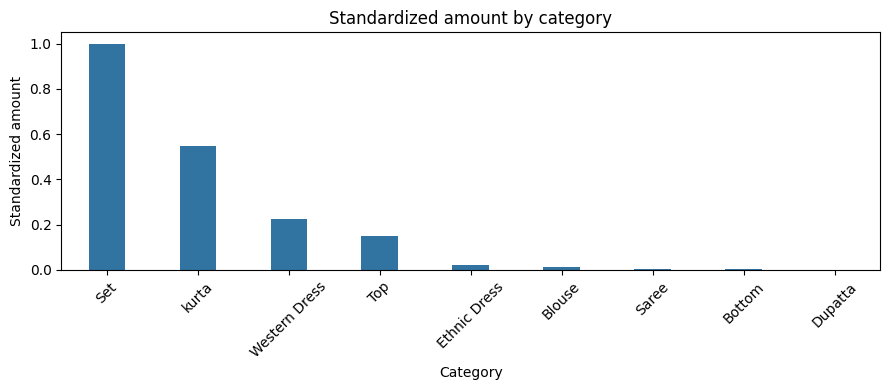

In [40]:
df_category_sorted = df_category.sort_values("total_amount", ascending=False)

plt.figure(figsize=(9, 4))
sns.barplot(data=df_category_sorted, x="Category", y="Standardized_Amount", width=0.4)

plt.title("Standardized amount by category")
plt.xlabel("Category")
plt.ylabel("Standardized amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
df_month=df_clean.groupBy("month").agg(
    count("Order ID").alias("orders"),
    sum("Amount").alias("total_amount")
).orderBy("orders", ascending=False)
df_month = df_month.toPandas()
df_month.set_index("month")

,orders,total_amount
month,,
4,30956,19558837.0
5,26692,17695951.0
6,25439,16711115.0
3,139,87464.0


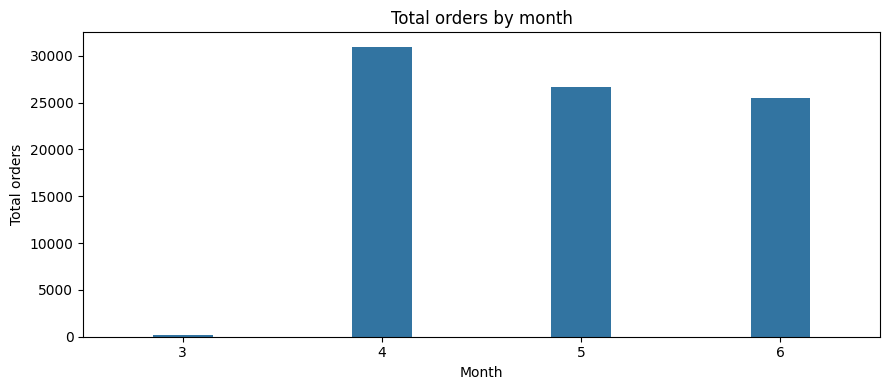

In [42]:
plt.figure(figsize=(9, 4))
sns.barplot(data=df_month, x="month", y="orders", width=0.3)

plt.title("Total orders by month")
plt.xlabel("Month")
plt.ylabel("Total orders")
plt.tight_layout()
plt.show()

##### TensorFlow deeplearning. Based on city-ship and amount, predict if the order will be cancelled.

In [43]:
#We'll focus on category "Top", so we filter the pyspark and create a pandas df.

Top_df = df_clean.filter(df_clean["Category"] == "Top")
Top_df_pandas = Top_df.toPandas()

#Also, for deeplearning we need Shipped and cancelled (but also cities) to be numbers
le = LabelEncoder()
Top_df_pandas['ship-city'] = le.fit_transform(Top_df_pandas['ship-city'].astype(str))
Top_df_pandas['Status'] = le.fit_transform(Top_df_pandas['Status'].astype(str))

In [ ]:
X = Top_df_pandas[['ship-city', 'Amount']]
y = Top_df_pandas['Status']

# Division in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Costruzione del modello
city_input = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='city_input')

# Embedding layer per 'ship-city'
city_embedding = tf.keras.layers.Embedding(input_dim=X['ship-city'].nunique(), output_dim=8)(city_input)
city_embedding_flat = tf.keras.layers.Flatten()(city_embedding)

# Input 'Amount'
amount_input = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='amount_input')

# Neural network
hidden_layer = tf.keras.layers.concatenate([city_embedding_flat, amount_input])
hidden_layer = tf.keras.layers.Dense(64, activation='relu')(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)

# Model
model = tf.keras.Model(inputs=[city_input, amount_input], outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    [X_train['ship-city'], X_train['Amount']], 
    y_train, 
    epochs=10, 
    validation_split=0.2, 
    batch_size=8 
)

# Evaluation
loss, accuracy = model.evaluate([X_test['ship-city'], X_test['Amount']], y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Esempio: inserisci manualmente i valori
input_city = int(input("Insert ship-city: "))
input_amount = float(input("Insert Amount: "))

city_array = tf.convert_to_tensor([[input_city]])
amount_array = tf.convert_to_tensor([[input_amount]])

# Prediction
prediction = model.predict([city_array, amount_array])
predicted_class = int(prediction[0][0] > 0.5)

# Output
print(f"\nProbability of 'Cancelled': {prediction[0][0]:.4f}")
print(f"Predicted class: {predicted_class} ({'Cancelled' if predicted_class == 0 else 'Shipped'})")



Epoch 1/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9188 - loss: 0.6267 - val_accuracy: 0.9250 - val_loss: 0.4516
Epoch 2/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9289 - loss: 0.4250 - val_accuracy: 0.9250 - val_loss: 0.2683
Epoch 3/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9355 - loss: 0.2916 - val_accuracy: 0.9250 - val_loss: 0.3230
Epoch 4/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9269 - loss: 0.3244 - val_accuracy: 0.9242 - val_loss: 0.3155
Epoch 5/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9274 - loss: 0.3345 - val_accuracy: 0.9087 - val_loss: 0.3068
Epoch 6/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9326 - loss: 0.2833 - val_accuracy: 0.9226 - val_loss: 0.3472
Epoch 7/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9272 - loss: 0.2869 - val_accuracy: 0.9185 - val_loss: 0.3476
Epoch 8/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9292 - loss: 0.2892 - val_accuracy: 0.